# Linear Programming Project 

## Problem description
There are 3 delivery depots in Vancouver, and need to delivery packages to 5 different areas, different areas have different demands of packages. How the delivery company assign their deliverers to different depots such that this optimal strategy can minimize the cost.

We simply consider all depots and delivery areas as nodes, and the connection between depots and delivery areas as roads, building a graph-based model. We first formulat a linear programming problme to solve a solution for best strategy to assign the number of delivery trips on each roads between depots and delivery areas such that the cost on runing the trips (the salary we should pay for the distance the delivery travel). 

Next, we base on the optimal solutions of trips assignment stategy build a new linear programming problem and solve it for the best choice to assign the number of works to each depost.


![](map.png)
<!-- <img src="map.png" height="600" width="600">  -->

## Variables and Parameters
|   Symbol   | Description                                                          |         Type         |
|:----------:| -------------------------------------------------------------------- |:--------------------:|
| $x_{ij}$ | The number of round trips happpen on the path from delivery depot $i$ to the delivery target area $j$ | Variable  |
| $y_i$     | The number of workers at depot $i$                              |   Variable  |
| $D_j$     | The demanded number of packages at delivery area $j$                      | parameter |
| $d_{ij}$     | The distance from depot $i$ to delivery area $j$               | parameter |
| $m$ | The number of delivery depots we have | parameter |
| $n$ | The number of delivery target area we have | parameter |
| $v$ | The speed of workers travel on the trip | parameter |
| $s$ | The basic salary of one worker | parameter |
| $c$ | The cost for $1km$ travel | parameter |
| $p$ | the number of packages a worker can take in one trip | parameter |
| $H$ | The maximun work time a worker per day | parameter |
| $W$ | The maximun number of workers at depot (same for all three) | parameter |


## Assumption and constraints
- There are only one worker in one path for one travel.
- The path between depots and target area is considered as a straight line.
- The demand can be always satisfied, i.e., the supply is always larger than demand.
- The demand number is seted based on the residential population in that area.
- The deliveryman must come back to deposit after deliver the packages.
- Suppose all the demanded packages can be delivered by all depots, rather than just one depot.


## Build solution

**Equation 1** :

First we minimize the cost we need to spend for total travels:
$$
\text{min} \sum_i \sum_j 2cd_{ij}x_{ij}
$$

The constraint for each target area to get enough demanded package by choosing the nunmber of delivery trips on each path:
$$
\sum_i px_{ij} \ge D_j \quad \forall j
$$

The constraint for each depot to make sure the workload needed (considered as work time) does not exceed the max work time this depot can provide:
$$
\sum_j 2\frac{d_{ij}}{v}x_{ij} \le WH \quad \forall i
$$

**Equation 2** :

After compute the optimal solution for the LP problem above, we get the best strategy to assign the number of round trip on each path, $x_{ij}^*$, which can be considered as a constant in this second problem.

Then we want to minimize the salary we need to pay to hire the delivery worker:
$$
\text{min} \sum_i sy_i
$$

The constraint for each depot to have enough number of workers such that they can satisfy the workload needed under the time limit:
$$
\begin{aligned}
Hy_i &\ge \sum_j 2\frac{d_{ij}}{v}x_{ij}^* \quad \forall i\\
y_i &\ge 0 \quad \forall i
\end{aligned}
$$


where,
$$
i = 1, \dots, m \\ j = 1, \dots, n
$$

### Compute the solutions

In [2]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import cvxpy as cp
from scipy.optimize import linprog

#### First LP problem

$$
\begin{array}{rc}
\text{minimize:} &\quad \sum_i \sum_j 2cd_{ij}x_{ij} \\
\text{subject to:} &\quad \sum_i px_{ij} \ge D_j \\
& \sum_j 2\frac{d_{ij}}{v}x_{ij} \le WH \\
& x_{ij} \ge 0
\end{array}
$$

In [3]:
# assign values to parameters
m = 3 # the number of depots
n = 6 # the number of target areas
v = 50 # the speed of deliveryman on the path
p = 50# the number of packages a deliveryman can carry with for one round trip
c = 1 # cost on travel 1km
H = 42 # the maximum working hours
W = 100 # the maximum workers can hired at one depot


d = np.array([[6.  , 8.7  , 22.2  , 22.5  , 8.4  , 6.9],
                 [14.1  , 5.1  , 16.5  , 14.1  , 6.0  , 7.8],
                 [18.6  , 8.1  , 6.6  , 7.2  , 15.9  , 18.]]) # distance of each path in km
D = np.array([209937, 249125, 568322, 148625, 58120, 662248]) # demanded packages in each area

In [4]:
# set decision variables
X = cp.Variable((m, n), integer=True) # X = [x_ij]

In [5]:
# set object function and constraints
obj_1 = cp.Minimize(cp.sum(cp.multiply(2*c*d, X)))
constraint1 = [p*cp.sum(X[:, j]) >= D[j] for j in range(n)]
constraint2 = [cp.sum(cp.multiply(2*d[i, :]/v, X[i, :])) <= W*H for i in range(m)]
constraint3 = [X >= 0]
constraints = constraint1 + constraint2 + constraint3

prob_1 = cp.Problem(obj_1, constraints)

In [6]:
prob_1.solve()

np.float64(493829.4)

In [7]:
X.value

array([[ 4199.,    -0.,    -0.,    -0.,    -0., 11566.],
       [   -0.,  4983.,    -0.,    -0.,  1163.,  1679.],
       [   -0.,    -0., 11367.,  2973.,    -0.,    -0.]])

**Visualize the problem**

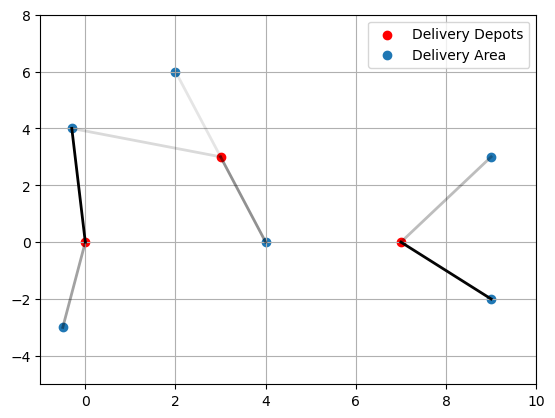

In [14]:
s_nodes = np.array([(0.,0.),(3.,3.),(7.,0.)])
d_nodes = np.array([(-0.5,-3.),(4.,0.),(9.,-2.),(9.,3.),(2.,6.),(-0.3,4.)])

plt.scatter(s_nodes[:,0],s_nodes[:,1],c='r')
plt.scatter(d_nodes[:,0],d_nodes[:,1])

max_X = X.value.max()

for i in range(m):
    for j in range(n):
        plt.plot([s_nodes[i,0],d_nodes[j,0]],[s_nodes[i,1],d_nodes[j,1]],c='k',lw=2,alpha=np.abs(X.value[i,j])/max_X)

plt.legend(['Delivery Depots','Delivery Area'],loc='upper right')
plt.xlim([-1,10]), plt.ylim([-5,8]), plt.grid(True)
plt.show()